# マルチエージェント・シミュレーションによる、<br/>ネットワーク上の進化ゲームの Frequently-Used Model

(進化ゲーム理論勉強会向け資料)

# 0. はじめに

## 0.1. モデルの全体像

1〜5でシミュレーションに必要な部品を用意して、6で一連のシミュレーションモデルとして組み上げ、7で結果を確認する。

1. Network の定義
1. Agent の定義
1. Model の定義
1. ゲームルールの定義
1. 戦略更新ルールの定義
1. シミュレーション実行プロシージャの定義
1. 実行&結果確認

## 0.2. Technology Stack

実装言語としては、[実行パフォーマンス](https://julialang.org/benchmarks/)及びモデル構築に必要なライブラリの充実度から**Julia**を推奨する。
遅くても良いならPythonやR等でも問題ないだろう。

グラフ(ネットワーク)処理系のライブラリは必須なので、良いグラフ処理系ライブラリを持たない言語を選ぶと後悔することになる。

MASライブラリ (フレームワーク) は必須ではないが、Juliaの場合、[Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/)がある。
インタラクティブなモデルを作る場合は使うと良いだろう。

In [1]:
using CSVFiles
using DataFrames
using Graphs
using GraphPlot, Plots
using Statistics: mean
using StatsBase: sample, Weights
using Test: @test, @testset, @test_throws

# 1. Network の定義

ネットワーク上での協力の進化なので、まずはネットワークを構築する必要がある。

とはいえ、JuliaやPythonなどの言語を使っていれば、自分で Barabasi Albert モデルや Erdos Renyi モデルを実装する必要はない。
車輪の再発明に時間を浪費することなく、[Graphs.jl](https://juliagraphs.org/Graphs.jl/stable/) や [NetworkX](https://networkx.org/) を使ってサクッとネットワークを構築できる。

例えば、スケールフリーネットワークなら、[Graphs.jl](https://juliagraphs.org/Graphs.jl/stable/) に用意されている`barabasi_albert` 関数を使って、こんな感じ↓で作ることができる。

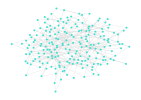

In [2]:
g = barabasi_albert(200, 2)
gplot(g)

後で使うために、汎用的なグラフ構築関数 (`make_graph`) を定義しておく。
ネットワークの種類としては、とりあえず、[レギュラーグラフ](https://ja.wikipedia.org/wiki/%E6%AD%A3%E5%89%87%E3%82%B0%E3%83%A9%E3%83%95)、[完全グラフ](https://ja.wikipedia.org/wiki/%E5%AE%8C%E5%85%A8%E3%82%B0%E3%83%A9%E3%83%95)、[ランダムグラフ](https://ja.wikipedia.org/wiki/%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E7%90%86%E8%AB%96#Erd%C5%91s-R%C3%A9nyi%EF%BC%88ER%EF%BC%89)、[スケールフリーネットワーク](https://ja.wikipedia.org/wiki/%E8%A4%87%E9%9B%91%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF#%E3%83%90%E3%83%A9%E3%83%90%E3%83%BC%E3%82%B7%E3%83%BB%E3%82%A2%E3%83%AB%E3%83%99%E3%83%AB%E3%83%88%E3%83%BB%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%88%E3%83%90%E3%83%A9%E3%83%90%E3%82%B7%E3%83%BB%E3%82%A2%E3%83%AB%E3%83%90%E3%83%BC%E3%83%88%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%89)の4種類を定義しておく (全て無向グラフ)。
Nはノード数、kは平均次数を表す。

In [3]:
@enum NetworkType complete regular grid random scale_free

function make_graph(network_type::NetworkType, N::Int, k::Int)::SimpleGraph
    if network_type == complete
        complete_graph(N)  # k は使わない。
    elseif network_type == regular
        random_regular_graph(N, k)  # connected graph になるとは限らないことに注意。
    elseif network_type == grid
        x = round(Int64, sqrt(N))
        Graphs.SimpleGraphs.grid((x, x), periodic = true)  # ノイマン近傍のラティス (k は使わない)。トーラス。
    elseif network_type == random
        erdos_renyi(N, Int(N * k / 2))  # connected graph になるとは限らないことに注意。
    elseif network_type == scale_free
        barabasi_albert(N, round(Int64, k / 2), complete = true)  # 平均次数はぴったり k にはならないことに注意。
    else
        throw(DomainError(network_type, "network_type is invalid."))
    end
end

make_graph (generic function with 1 method)

##### Test

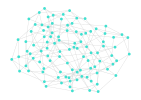

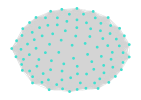

is_connected(g) = false


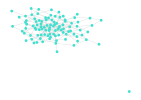

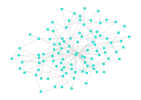

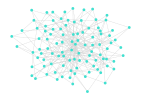

In [4]:
## regular_graph
g = make_graph(regular, 100, 4)
@test is_connected(g)
@test nv(g) == 100
@test degree(g) == fill(4, 100)
display(gplot(g))

## complete_graph
g = make_graph(complete, 100, 4)
@test is_connected(g)
@test nv(g) == 100
@test degree(g) == fill(99, 100)
display(gplot(g))

## random_graph
g = make_graph(random, 100, 4)
@show is_connected(g)
@test nv(g) == 100
@test degree(g) != fill(4, 100)
@test mean(degree(g)) == 4
display(gplot(g))

## scale_free
g = make_graph(scale_free, 100, 4)
@test is_connected(g)
@test nv(g) == 100
@test degree(g) != fill(4, 100)
@test mean(degree(g)) == 3.94
display(gplot(g))

## scale_free
g = make_graph(scale_free, 100, 6)
@test is_connected(g)
@test nv(g) == 100
@test degree(g) != fill(5, 100)
@test mean(degree(g)) == 5.88
display(gplot(g))

# 2. Agent の定義

各エージェントが持つ属性 (id、戦略、ペイオフ、適応度) を保持する入れ物です。

In [5]:
@enum Strategy C D

mutable struct Agent
    id::Int
    strategy::Strategy
    payoff::Float64
    fitness::Float64

    # Constructor
    # Agent(id) = new(id, id == 1 ? C : D, 0.0, 0.0)
    Agent(id) = new(id, rand([C, D]), 0.0, 0.0)
end

##### Test

In [6]:
# Test
@testset "Agent" begin
    agent = Agent(12)
    @test agent.id == 12
    @test agent.payoff == agent.fitness == 0.0
    @test mean([Agent(id).strategy == C for id in 1:1000]) ≈ 0.5 atol = 0.1
end

Test Summary: | Pass  Total  Time
Agent         |    3      3  0.1s


Test.DefaultTestSet("Agent", Any[], 3, false, false, true, 1.665654071555691e9, 1.665654071677473e9)

# 3. Model の定義

ネットワーク構造、エージェントの配列、シミュレーション全体で共通のパラーメータを保持する入れ物です。

In [7]:
mutable struct Model
    graph::SimpleGraph{Int64}
    agents::Vector{Agent}

    b::Float64  # benefit multiplying factor
    c::Float64  # game contribution
    μ::Float64  # mutation rate
    δ::Float64  # selectin parameter

    # Constructor
    Model(graph::SimpleGraph{Int64}, b::Float64) = new(
        graph,
        [Agent(id) for id in vertices(graph)],
        b,
        1.0,
        0.01,
        0.1
    )
end

get_agent_by_id(model::Model, id::Int)::Agent = [agent for agent in model.agents if agent.id == id][1]

reset_agents!(model::Model) = [(agent.payoff, agent.fitness) = (0.0, 0.0) for agent in model.agents]

cooperation_rate(model::Model)::Float64 = mean([agent.strategy == C for agent in model.agents])

cooperation_rate (generic function with 1 method)

##### Test

In [8]:
@testset "Model" begin
    graph = make_graph(random, 100, 4)
    model = Model(graph, 4.5)
    @test [agent.id for agent in model.agents] == 1:100
    @test mean([agent.strategy == C for agent in model.agents]) ≈ 0.5 atol = 0.1
    @test [agent.payoff for agent in model.agents] == fill(0.0, 100)
    @test [agent.fitness for agent in model.agents] == fill(0.0, 100)
    @test model.b == 4.5
    @test model.c == 1.0
    @test model.μ == 0.01
    @test model.δ == 0.1
end

@testset "get_agent_by_id" begin
    graph = make_graph(random, 100, 4)
    model = Model(graph, 4.5)
    @test get_agent_by_id(model, 50) == model.agents[50]
end

@testset "reset_agents!" begin
    graph = make_graph(random, 100, 4)
    model = Model(graph, 4.5)
    for agent in model.agents
        agent.payoff, agent.fitness = 1.0, 1.0
    end
    reset_agents!(model)
    @test [agent.payoff for agent in model.agents] == fill(0.0, 100)
    @test [agent.fitness for agent in model.agents] == fill(0.0, 100)
end

Test Summary: | Pass  Total  Time
Model         |    8      8  0.1s
Test Summary:   | Pass  Total  Time
get_agent_by_id |    1      1  0.0s
Test Summary: | Pass  Total  Time
reset_agents! |    2      2  0.0s


Test.DefaultTestSet("reset_agents!", Any[], 2, false, false, true, 1.665654072052704e9, 1.665654072087502e9)

# 4. ゲームルールの定義

典型的なパターンとしては、2人ゲームとN人ゲームがある。

## 1. 各エージェントが自分の隣人の中から一人ランダムに選んで、2人ゲームを行う。

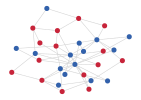

In [38]:
# 説明用グラフ
node_count = 30
g = make_graph(scale_free, node_count, 4)
gplot(g, nodefillc=[x % 2 == 0 ? "#C7243A" : "#3261AB" for x in 1:node_count], nodelabelc="white")

- 利得行列を下記の様に定義すると、b/c比率で囚人のジレンマゲームを定義できる。(b > 0, c > 0)

||C|D|
|:-:|:-:|:-:|
|C|b-c|-c|
|D|b|0|

- 利得行列を下記の様に定義すると、囚人のジレンマゲーム、スノードリフトゲーム、スタグハントゲームを統一的な枠組みで表現できる。

||C|D|
|:-:|:-:|:-:|
|C|1|S|
|D|T|0|

|Game|Parameters|
|:-:|:-:|
|囚人のジレンマ (PD)|T > 1 > 0 > S|
|スノードリフトゲーム (SG)|T > 1 > S > 0|
|スタグハントゲーム (SH)|1 > T > 0 > S|

## 2. 各エージェントが自分の隣人全員もしくは数人ランダムに選んで、N人ゲームを行う。

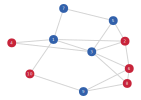

In [10]:
# 説明用グラフ
g = make_graph(scale_free, 10, 4)
gplot(g, nodelabel=1:10, nodefillc=[x % 2 == 0 ? "#C7243A" : "#3261AB" for x in 1:10], nodelabelc="white")

- いわゆる公共財ゲーム。
- 利得構造は b と c で決まる。
- 次数が大きいノードと次数が小さいノードが混在している場合は、ペイオフを正規化する方法として下記の3パターンがある。
    - 正規化しない。
    - 拠出金を正規化する (Santos2008)。
    - 利得を正規化する (???)。
    
以下、2人ゲームの実装例。

In [11]:
function calc_payoff!(model::Model)
    for agent in model.agents
        opponent_id = rand(neighbors(model.graph, agent.id))
        opponent = get_agent_by_id(model, opponent_id)

        if agent.strategy == C && opponent.strategy == C
            agent.payoff += (model.b - model.c)
            opponent.payoff += (model.b - model.c)
        elseif agent.strategy == C && opponent.strategy == D
            agent.payoff -= model.c
            opponent.payoff += model.b
        elseif agent.strategy == D && opponent.strategy == C
            agent.payoff += model.b
            opponent.payoff -= model.c
        end
    end
end

calc_payoff! (generic function with 1 method)

##### Test

In [12]:
@testset "calc_payoff!" begin
    graph = make_graph(complete, 3, 3)
    model = Model(graph, 3.0)
    model.agents[1].strategy = C
    model.agents[2].strategy = D
    model.agents[3].strategy = D
    @show [agent.payoff for agent in model.agents]
    calc_payoff!(model)
    @show [agent.payoff for agent in model.agents]
end

[agent.payoff for agent = model.agents] = [0.0, 0.0, 0.0]
[agent.payoff for agent = model.agents] = [-2.0, 6.0, 0.0]
Test Summary: |Time
calc_payoff!  | None  0.1s


Test.DefaultTestSet("calc_payoff!", Any[], 0, false, false, true, 1.665654072870417e9, 1.665654072933392e9)

# 5. 戦略更新ルールの定義

「利得 (payoff)」を「適応度 (fitness)」に変換して、適応度が高い個体 (戦略) が増えて、適応度が低い個体 (戦略) が減るアルゴリズムを定義する。

生物進化の文脈ではこのアルゴリズムを繁殖と呼び、文化進化の文脈では学習や模倣と呼ぶことが多い。

## 利得→適応度変換

利得を適応度に変換する際は、「弱い選択 (Weak Selection)」と呼ばれる考え方を適用する。

弱い選択とは、ゲームの結果蓄積した利得の大小によってだけで、どの個体(戦略)が生き残るかが決まるのではなく、ゲームの結果(利得)以外にも偶然や未知の因果関係などによって、個体の生き残りやすさ(適応度)は変わってくる。そうした、考え方をもとに、利得を適応度に変換する考え方を「弱い選択 (Weak Selection)」と呼び、以下の式で表す。

$$F = 1 - \delta + \delta P$$

- P: 利得 (payoff)
- F: 適応度 (fitness)
- $\delta$: 選択の強さ (淘汰の強さ)

$\delta << 1$ という条件を、「弱い選択 (Weak Selection)」と呼ぶ。シミュレーションでWeak Selectionというときは、一般に $\delta = 0.1$ ぐらいで計算する。

$\delta = 0$ のケースを、中立的浮動 (モラン過程) といい、解析解を出せる場合もある。(Nowak (2006) 『進化のダイナミクス』第6章 有限集合)

以下、実装例。

In [13]:
function set_fitness!(model::Model)
    for agent in model.agents
        agent.fitness = 1 - model.δ + model.δ * agent.payoff
    end
end

set_fitness! (generic function with 1 method)

##### Test

In [14]:
graph = make_graph(complete, 3, 1)
model = Model(graph, 1.0)
model.agents[1].payoff = 1.0
model.agents[2].payoff = 2.0
model.agents[3].payoff = 4.0

model.δ = 0.0
set_fitness!(model)
@test model.agents[1].fitness == 1.0
@test model.agents[2].fitness == 1.0
@test model.agents[3].fitness == 1.0

model.δ = 0.1
set_fitness!(model)
@test model.agents[1].fitness == 1.0
@test model.agents[2].fitness == 1.1
@test model.agents[3].fitness == 1.3

model.δ = 1.0
set_fitness!(model)
@test model.agents[1].fitness == 1.0
@test model.agents[2].fitness == 2.0
@test model.agents[3].fitness == 4.0

Test Passed

## 戦略更新ルール

適応度に応じて戦略を更新するパターンとしては、「Death-birth」「Birth-death」「Imitation」がある。論文の本文ではどれか一つを選んで、Appendixに全パターンを試した結果を記載してモデルの頑強性を示すことが多い。

以下、実装例。詳細はコメント参照。

In [15]:
@enum UpdateRule Bd Db IM

# Nowak (2006) 『進化のダイナミクス』第8章 進化グラフ理論 P.124-125
function update_strategy!(model::Model, update_rule::UpdateRule)
    set_fitness!(model)
    
    if update_rule == Bd
        # Birth-death
        # 各時間ステップ毎に各個体はその適応度に比例して繁殖のために選ばれる。
        parent_agent = sample(model.agents, Weights([agent.fitness for agent in model.agents]))
        # 子はランダムに選ばれた隣人を置き換える。
        dying_agent_id = rand(neighbors(model.graph, parent_agent.id))
        dying_agent = get_agent_by_id(model, dying_agent_id)
        dying_agent.strategy = parent_agent.strategy
    elseif update_rule == Db
        # Death-birth
        # 各時間ステップ毎に死ぬ個体がランダムに選ばれる。
        dying_agent = rand(model.agents)
        # 隣人たちは、彼らの適応度に比例した強さで、空き地を巡って競争する。
        neighbor_agents_id = neighbors(model.graph, dying_agent.id)
        neighbor_agents = [get_agent_by_id(model, id) for id in neighbor_agents_id]
        parent_agent = sample(neighbor_agents, Weights([agent.fitness for agent in neighbor_agents]))
        dying_agent.strategy = parent_agent.strategy
    elseif update_rule == IM
        # Imitation
        # 各時間ステップ毎に個体はランダムに選ばれ、その戦略を更新する。
        # 個体はそれぞれの適応度に比例した確率で、自身の戦略に留まるか隣人の戦略を模倣する。
        student_agent = rand(model.agents)
        teacher_agent_id = rand(neighbors(model.graph, student_agent.id))
        teacher_agent = get_agent_by_id(model, teacher_agent_id)
        # Pairwise-Fermi Comparison
        probability_of_imitation = pairwise_fermi(student_agent.fitness, teacher_agent.fitness)
        if probability_of_imitation > rand()
            student_agent.strategy = teacher_agent.strategy
        end
    else
        throw(DomainError(update_rule, "update_rule is invalid."))
    end
end

update_strategy! (generic function with 1 method)

## ペアワイズ・フェルミ関数

エージェントAとBがいるとする。AがBを真似るか真似ないかを決めたい。

- 適応度の差に応じて0.0〜1.0の間の値を出力したい。
- 適応度の差が正に大きければ大きいほど1.0に近く、差が負に大きければ大きいほど0.0に近い確率を出力したい。
- 適応度の差がなければ50%の確率を出力したい。

こういった要請に応えるために、良く採用されるのが、ペアワイズ・フェルミ関数であり、以下の様な形をしている。

$$p = \frac{1}{1 + e^\frac{\pi_i - \pi_j}{\kappa}}$$

以下、実装例。(弱い選択を入れずに直接利得の差を見ても良いと思う。)

In [16]:
pairwise_fermi(πᵢ::Float64, πⱼ::Float64, κ::Float64 = 0.1)::Float64 = 1 / (1 + exp((πᵢ - πⱼ) / κ))

pairwise_fermi (generic function with 2 methods)

In [17]:
@test [pairwise_fermi(1.0, _x) for _x in 0.0:0.5:2.0] ≈ [0.0, 0.0067, 0.5, 0.9933, 1.0] atol = 10^-4

x = 0.0:0.01:2.0
y = [pairwise_fermi(1.0, _x, 0.1) for _x in x]
plot(
    x,
    y,
    title = "Pairwise-Fermi Function (Student's fitness = 1.0)",
    xlabel = "Teacher's fitness",
    ylabel = "Probability of imitation",
    legend = NaN
)

# 6. シミュレーション実行プロシージャの定義

特に典型的なパターンなどはないので、好きなようにすれば良い。

In [18]:
function run!(;network_type::NetworkType, N::Int, k::Int, b::Float64, update_rule::UpdateRule, generation::Int)::Float64
    graph = make_graph(network_type, N, k)
    model = Model(graph, b)
    
    for _ in 1:generation
        calc_payoff!(model)
        update_strategy!(model, update_rule)
        reset_agents!(model)

        if cooperation_rate(model::Model) == 0.0 || cooperation_rate(model::Model) == 1.0
            return cooperation_rate(model::Model)
        end
    end

    return cooperation_rate(model::Model)
end

run! (generic function with 1 method)

In [19]:
# 動作確認
run!(
    network_type = scale_free,
    N = 500,
    k = 4,
    b = 5.5,  # ゲームルール定義 (b/c比率)
    update_rule = Db,  # 戦略更新ルール定義
    generation = 100
)

0.544

# 7. 実行&結果確認

結果は、固定確率で見る場合と、戦略の分布で見る場合がある。

## 固定確率

2つの戦略A, B間のゲームにおいて、Aの固定確率とは、N - 1 人のBプレイヤーの集団にいる 1 人の A プレイヤーが A の子孫を産み、その系統が絶滅せずに集団全体を占める確率のことである。Aの固定化確率が1/Nよりも大きければ、AはBよりも進化しやすいことになる。

固定確率は、Cの戦略分布 (協力率) が0%か100%に収束する場合にしか使えない。収束しないことが多い場合は、単純に協力率を見る。

また、スケールフリーネットワーク上での協力の進化の様に、複数のエージェントがコミュニティを形成することによって、協力戦略が進化するようなモデルの場合は、初期状態が1:N-1だと、妥当な結果が出ない。

固定確率を使うメリットは、中立的浮動(モラン過程)の場合の解析解と結果を比較できること。

## 戦略の分布

2つの戦略A, B間のゲームにおいて、A:50% / B:50% の戦略分布でシミュレーションを開始し、シミュレーションが進むにつれてその戦略分布がどの様に変化するかを見て結果を確認する。以下、実装例。

In [20]:
# 定数
trial = 100
N = 300
k = 4
generation = 10000

# シミュレーションパターン
network_type_list = [scale_free, grid, complete]
b_list = 1:0.25:6
update_rule_list = [Bd Db IM]
simulation_pattern = vec(collect(Base.product(network_type_list, b_list, update_rule_list)))

# 結果を格納するためのDFを作成
df = DataFrame(simulation_pattern)
rename!(df, [:network_type, :b, :update_rule])
df.cooperation_rate .= 0.0
@show size(df)
@show first(df, 10)

# 実行
@show Threads.nthreads()  # 10
@time begin  # 2482.344515 seconds
    Threads.@threads for (network_type, b, update_rule) in simulation_pattern
        _result_list = [run!(;network_type, N, k, b, update_rule, generation) for _ in 1:trial]
        df[
            (df[:, :network_type] .== network_type) .&&
            (df[:, :b] .== b) .&&
            (df[:, :update_rule] .== update_rule), :cooperation_rate
        ] .= mean(_result_list)
    end
end

# 実行結果を保存
save("FUM.csv", df)

size(df) = (189, 4)
first(df, 10) = 10×4 DataFrame
 Row │ network_type  b        update_rule  cooperation_rate
     │ NetworkType   Float64  UpdateRule   Float64
─────┼──────────────────────────────────────────────────────
   1 │ scale_free       1.0   Bd                        0.0
   2 │ grid             1.0   Bd                        0.0
   3 │ complete         1.0   Bd                        0.0
   4 │ scale_free       1.25  Bd                        0.0
   5 │ grid             1.25  Bd                        0.0
   6 │ complete         1.25  Bd                        0.0
   7 │ scale_free       1.5   Bd                        0.0
   8 │ grid             1.5   Bd                        0.0
   9 │ complete         1.5   Bd                        0.0
  10 │ scale_free       1.75  Bd                        0.0
Threads.nthreads() = 1


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:459[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:478[24m[39m[90m [inlined][39m
      [3] [0m[1mempty[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:860[24m[39m[90m [inlined][39m
      [4] [0m[1mgrow_to![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{Agent}[39m, [90mitr[39m::[0mBase.Generator[90m{Base.Iterators.Filter{var"#5#6"{Int64}, Vector{Agent}}, typeof(identity)}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:862[24m[39m
      [5] [0m[1mcollect[22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:784[24m[39m[90m [inlined][39m
      [6] [0m[1mget_agent_by_id[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[7]:21[24m[39m[90m [inlined][39m
      [7] [0m[1mcalc_payoff![22m[0m[1m([22m[90mmodel[39m::[0mModel[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[11]:4[24m[39m
      [8] [0m[1mrun![22m[0m[1m([22m; [90mnetwork_type[39m::[0mNetworkType, [90mN[39m::[0mInt64, [90mk[39m::[0mInt64, [90mb[39m::[0mFloat64, [90mupdate_rule[39m::[0mUpdateRule, [90mgeneration[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[18]:6[24m[39m
      [9] [0m[1m(::var"#43#46"{UpdateRule, Float64, NetworkType})[22m[0m[1m([22m[90m#unused#[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mnone:0[24m[39m
     [10] [0m[1miterate[22m
    [90m    @ [39m[90m./[39m[90m[4mgenerator.jl:47[24m[39m[90m [inlined][39m
     [11] [0m[1mcollect_to![22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:845[24m[39m[90m [inlined][39m
     [12] [0m[1mcollect_to_with_first![22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:823[24m[39m[90m [inlined][39m
     [13] [0m[1mcollect[22m[0m[1m([22m[90mitr[39m::[0mBase.Generator[90m{UnitRange{Int64}, var"#43#46"{UpdateRule, Float64, NetworkType}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:797[24m[39m
     [14] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[20]:24[24m[39m[90m [inlined][39m
     [15] [0m[1m(::var"#250#threadsfor_fun#44"{var"#250#threadsfor_fun#42#45"{Vector{Tuple{NetworkType, Float64, UpdateRule}}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [16] [0m[1m#250#threadsfor_fun[22m
    [90m    @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [17] [0m[1m(::Base.Threads.var"#1#2"{var"#250#threadsfor_fun#44"{var"#250#threadsfor_fun#42#45"{Vector{Tuple{NetworkType, Float64, UpdateRule}}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m